# ABC calibration of $I_\text{to}$ in standardised model to unified dataset.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Wang1993]
 - Activation time constant [Courtemanche1998]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Wang1993]
 - Inactivation time constant [Courtemanche1998]
 - Recovery time constant [Courtemanche1998]

In [1]:
from experiments.ito_wang import wang_act, wang_inact
from experiments.ito_courtemanche import (courtemanche_kin,
                                          courtemanche_rec,
                                          courtemanche_deact,
                                          courtemanche_act_kin,
                                          courtemanche_inact_kin)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/standardised_ito.mmt'

Plot steady-state and tau functions of original model

In [3]:
from ionchannelABC.visualization import plot_variables

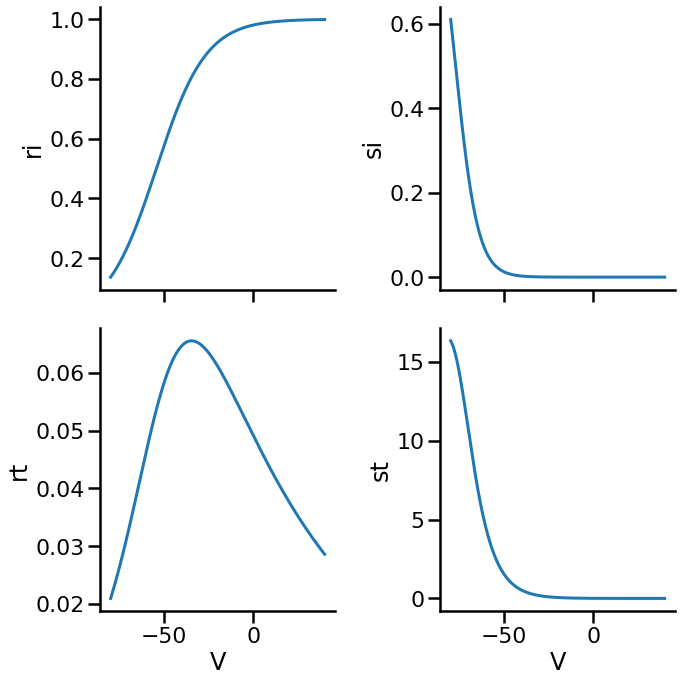

In [8]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_par_map = {'ri': 'ito.r_ss',
            'si': 'ito.s_ss',
            'rt':  'ito.tau_r',
            'st': 'ito.tau_s'}

f, ax = plot_variables(V, sta_par_map, 'models/standardised_ito.mmt', figshape=(2,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act,
                                                wang_inact,
                                                courtemanche_kin,
                                                courtemanche_deact,
                                                courtemanche_rec)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [11]:
limits = {'log_ito.p_1': (-7, 3),
          'ito.p_2': (1e-7, 0.4),
          'log_ito.p_3': (-7, 3),
          'ito.p_4': (1e-7, 0.4),
          'log_ito.p_5': (-7, 3),
          'ito.p_6': (1e-7, 0.4),
          'log_ito.p_7': (-7, 3),
          'ito.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [12]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ito.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.0858980949944816, '1': 1.0858980949944816, '2': 1.0858980949944816, '3': 0.4192258490995194, '4': 0.4514739913379436, '5': 0.5335601715812083, '6': 0.7825549183191034, '7': 1.0858980949944816, '8': 1.0858980949944816, '9': 0.6224264374795091, '10': 0.5705575676895505, '11': 0.526668524021124, '12': 0.6224264374795091, '13': 0.5705575676895536, '14': 0.3112132187397554, '15': 0.23609278663015926, '16': 0.5705575676895505, '17': 0.5705575676895563, '18': 0.5266685240211265, '19': 0.6224264374795127, '20': 0.5705575676895563, '21': 0.6224264374795127, '22': 0.5429490474972408, '23': 0.6248364448246935, '24': 1.0858980949944816, '25': 1.0858980949944816, '26': 1.0858980949944816, '27': 1.0858980949944816, '28': 1.0858980949944816, '29': 1.0858980949944816, '30': 1.0858980949944816, '31': 0.5429490474972408, '32': 1.0858980949944816, '33': 1.0858980949944816, '34': 1.0858980949944816, '35': 1.0858980949944816, '36': 1.0858980949944816, '37': 1.08589809

In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-23 06:31:26.461343, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Analysis of results

In [13]:
history = History('sqlite:///results/standardised/ito/standardised_ito.db')

In [14]:
df, w = history.get_distribution(m=0)

In [15]:
df.describe()

name,ito.p_2,ito.p_4,ito.p_6,ito.p_8,log_ito.p_1,log_ito.p_3,log_ito.p_5,log_ito.p_7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.070762,0.025261,0.059005,0.087277,-2.254317,-0.718321,-0.972691,-3.527100
std,0.001632,0.000412,0.001360,0.002012,0.023766,0.010716,0.012873,0.054026
min,0.064353,0.024182,0.053037,0.078786,-2.373233,-0.748374,-1.018168,-3.671535
25%,0.069891,0.024975,0.058257,0.086857,-2.269348,-0.725527,-0.981241,-3.558575
50%,0.070943,0.025253,0.059187,0.087643,-2.256585,-0.718012,-0.972998,-3.535215
75%,0.071939,0.025542,0.059924,0.088406,-2.235551,-0.710853,-0.963579,-3.512150
max,0.074415,0.026525,0.061756,0.092377,-2.205816,-0.691626,-0.932882,-3.306289


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


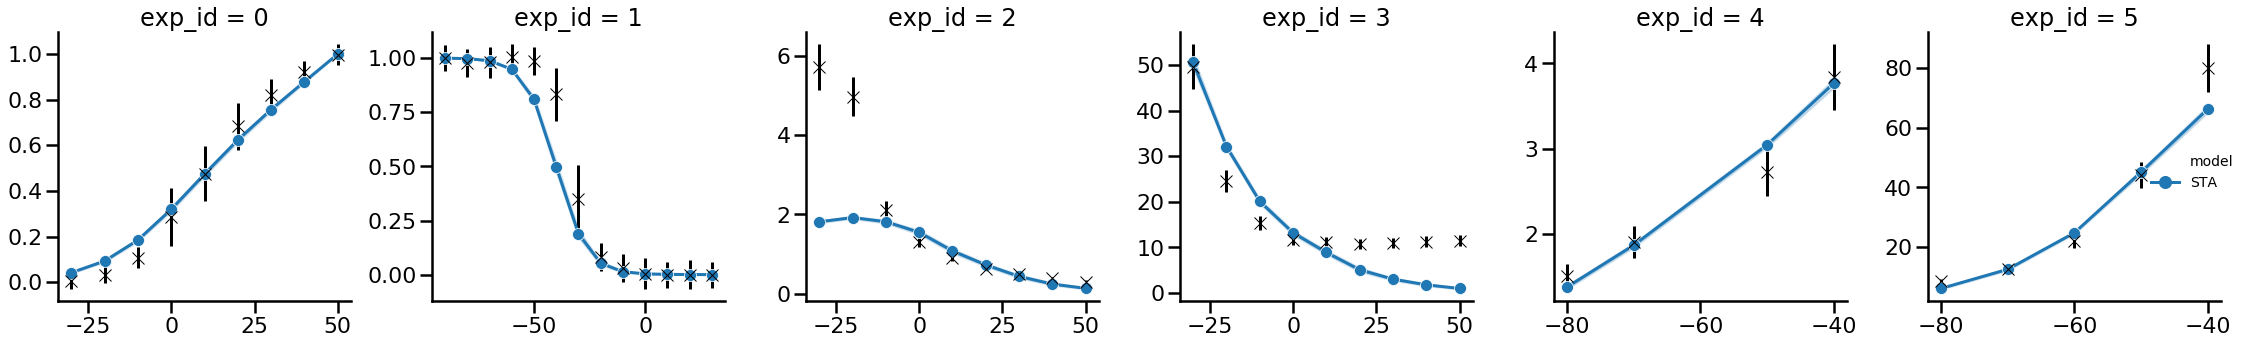

In [16]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     wang_act,
                     wang_inact,
                     courtemanche_kin,
                     courtemanche_deact,
                     courtemanche_rec,
                     df=df, w=w)

plt.tight_layout()

In [17]:
import pandas as pd
N = 100
sta_par_samples = df.sample(n=N, weights=w, replace=True)
sta_par_samples = sta_par_samples.set_index([pd.Index(range(N))])
sta_par_samples = sta_par_samples.to_dict(orient='records')

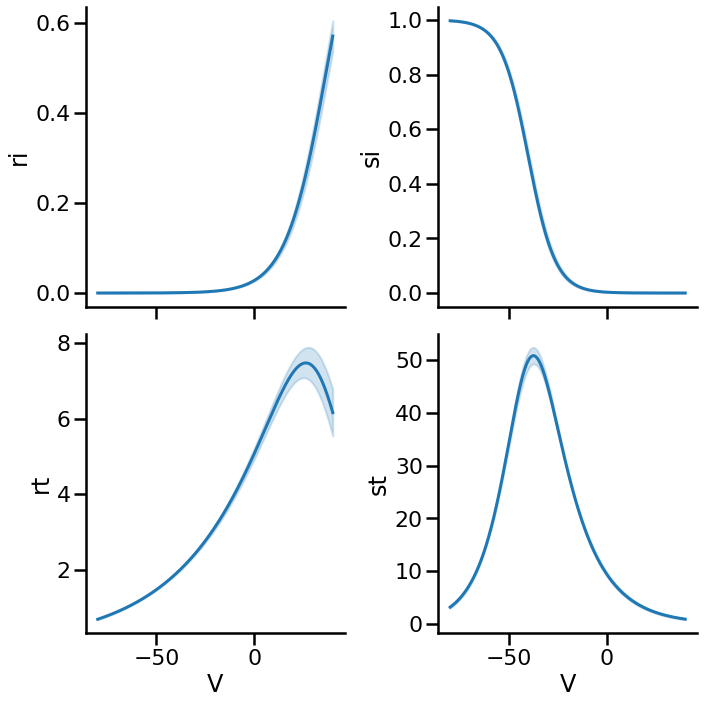

In [18]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_par_map, 
                       'models/standardised_ito.mmt', 
                       [sta_par_samples],
                       figshape=(2,2))
plt.tight_layout()

In [19]:
m,_,_ = myokit.load(modelfile)

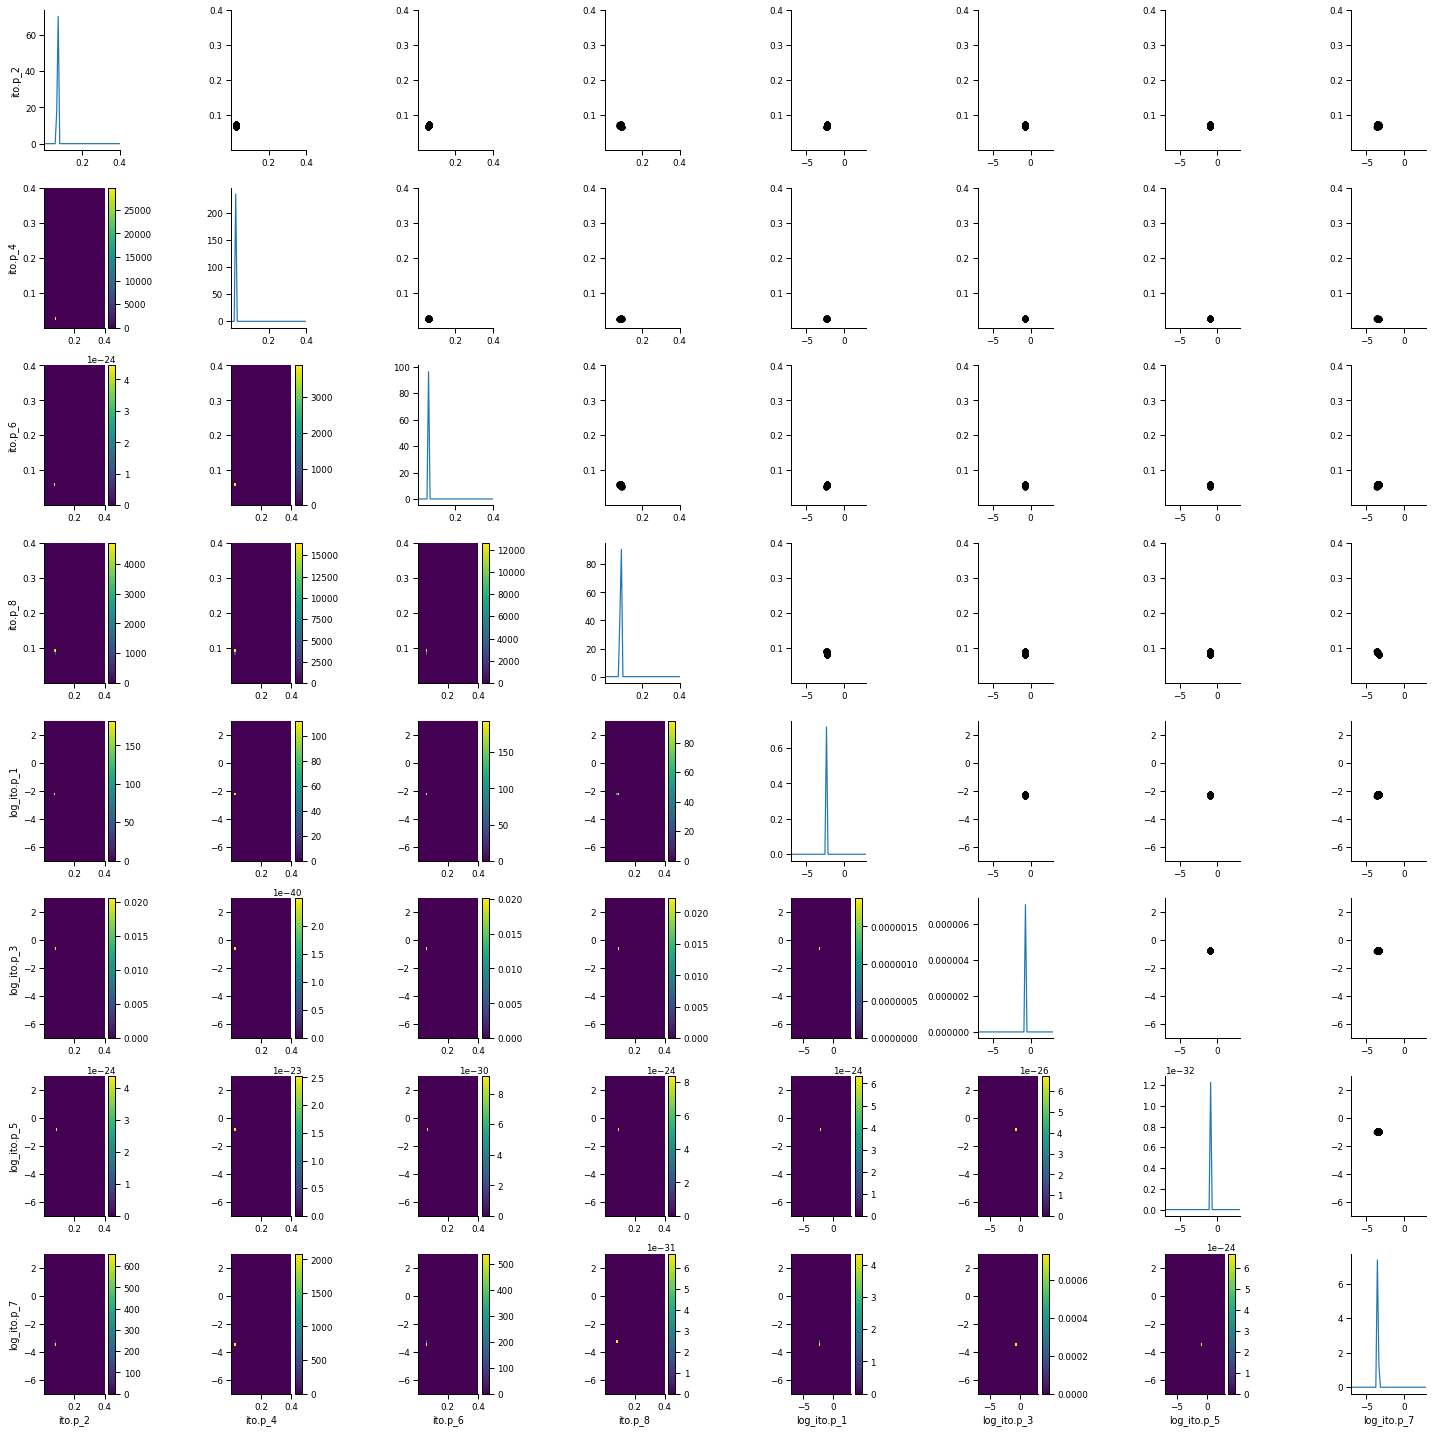

In [20]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()